# DimensionReduction: Visualize Embedding Space

DNIKit provides a [DimensionReduction](https://apple.github.io/dnikit/api/dnikit/introspectors.html#dnikit.introspectors.DimensionReduction) introspector with a variety of strategies (dimension reduction algorithms).  ``DimensionReduction`` has two primary uses:

- reduce high dimension data to something lower for consumption by a different introspector
    - for example [Familiarity](https://apple.github.io/dnikit/api/dnikit/introspectors.html#dnikit.introspectors.Familiarity) works best on low dimension data, e.g. 40 dimensions
    - many embedding spaces are much higher dimension, e.g. 1024
    - in fact some of the ``DimensionReduction`` algorithms work best on lower dimension data
    - this is typically accomplished with using the [PCA](https://apple.github.io/dnikit/api/dnikit/introspectors.html#dnikit.introspectors.DimensionReduction.Strategy.PCA) strategy first
- reduction to 2D or 3D for visualization
    - there are several strategies that do a good job

This notebook shows examples of both of these:  reducing high dimension data to lower dimension and producing 2D projections for visualization.

The examples here use CIFAR-10 (image classification dataset with 10 classes) and `mobilenet_v2` to produce an embedding space.

First, import all the packages needed:

In [1]:
import numpy as np
import typing as t
import dataclasses

# dnikit / dimension reduction
from dnikit.base import (
    Batch, Producer, pipeline,
    ImageFormat
)
from dnikit.processors import (
    Processor,
    ImageResizer,
    Cacher,
    Pooler,
)
from dnikit.introspectors import DimensionReduction

# for inference
import logging
from dnikit_tensorflow import TFModelExamples, TFDatasetExamples

# graphing
import matplotlib.pyplot as plt

## Dataset + Model to Produce Embeddings

Next load the CIFAR10 dataset and MobileNet to produce the embedding using [TFModelExamples](https://apple.github.io/dnikit/api/dnikit_tensorflow/index.html#dnikit_tensorflow.TFModelExamples) and [TFDatasetExamples](https://apple.github.io/dnikit/api/dnikit_tensorflow/index.html#dnikit_tensorflow.TFDatasetExamples). See [load a model](https://apple.github.io/dnikit/how_to/connect_model.html) or [load data](https://apple.github.io/dnikit/how_to/connect_data.html) for more information about how to customize this step to specific needs.

In [2]:
logging.basicConfig(level=logging.INFO)

# Load MobileNet and CIFAR10
cifar10 = TFDatasetExamples.CIFAR10(attach_metadata=True)
cifar10_test = cifar10.subset(datasets=["test"])

mobilenet = TFModelExamples.MobileNet()

2023-08-03 12:39:26.837930: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-08-03 12:39:26.837954: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-08-03 12:39:26.837957: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-08-03 12:39:26.837989: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-03 12:39:26.838005: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


/private/tmp/dnikit-2.0.0/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:dnikit_tensorflow.TF2:Instantiating TF2 Model


INFO:dnikit_tensorflow.TF2:GPUs Available: 1


Define the inference pipeline -- it will produce a field named `'conv_pw_13'` that has the embedding to visualize.  This is a 1024-dimension vector to be shown in 2 dimensions.

In [3]:
mobilenet_preprocessor = mobilenet.preprocessing
assert mobilenet_preprocessor is not None

preprocessing_stages = (

    # First, grab MobileNet's preprocessing acts as a DNIKit Processor
    mobilenet_preprocessor,

    # Next, define the second processor for the data, - ImageResizer to 224x224.
    ImageResizer(pixel_format=ImageFormat.HWC, size=(224, 224)),
)

producer = pipeline(
    # Use the cifar10 test dataset
    cifar10_test,

    # Apply previously-defined preprocessing stages for Mobilenet & CIFAR
    *preprocessing_stages,

    # run inference -- pass a list of requested responses or a single string
    mobilenet.model(requested_responses='conv_pw_13'),

    # perform spatial max pooling on the result
    Pooler(dim=(1, 2), method=Pooler.Method.MAX),

    # Cache results to re-run the pipeline without recomputing the responses
    Cacher()
)

BATCH_SIZE = 128

## Visualization

First a helper function that will extract the 2d projection and build a graph with one scatter plot per class (type of image, e.g. car or frog) -- this allows us to assign a different color per class.

In [4]:
from collections import defaultdict

def show(producer: Producer) -> None:
    data: t.Dict[t.Hashable, t.Any] = defaultdict(list)
    for batch in producer(1000):
        for e in batch.elements:
            f = e.fields["conv_pw_13"]
            c = e.metadata[Batch.StdKeys.LABELS]["label"]
            data[c] = np.append(data[c], f)

    fig, ax = plt.subplots(dpi=200)
    for c, d in data.items():
        ax.scatter(d[::2], d[1::2], c=f'C{c}', s=2)

## Dimension Reduction

Dimension reduction is a two-step process.  First, the [DimensionReduction.introspect()](https://apple.github.io/dnikit/api/dnikit/introspectors.html#dnikit.introspectors.DimensionReduction.introspect) call is made to observe the contents of a pipeline and fit a model to the data.  This produces a ``reducer`` that can be used to reduce the data:

```
reducer = DimensionReduction.introspect(producer, strategies=DimensionReduction.Strategy.PCA(40))
```

This means that all of the algorithms require visiting the data twice: once to fit and again to do the projection.  All but PCA require accumulating the entire dataset in memory in order to produce the fit.  Because the data is read twice, it's suggested to ensure that the pipeline being used is either very fast or use a [Cacher](https://apple.github.io/dnikit/api/dnikit/processors.html#dnikit.processors.Cacher) to cache the results of the inference.

In the case of PCA, the reducer can be applied to any other (hopefully related) pipeline.  The other algorithms must apply to the same data that they were fit to.

```
# apply the projection to the original 1024-dimension data -- reduced_producer
# produces batches with 40 dimensions.
reduced_producer = pipeline(producer, reducer)
```

### PCA

Principal Component Analysis can be used to do dimension reduction to any number of target dimensions:

> PCA is used to decompose a multivariate dataset in a set of successive orthogonal components that explain a maximum amount of the variance. In scikit-learn, PCA is implemented as a transformer object that learns n components in its fit method, and can be used on new data to project it on these components.

PCA is fast and convenient to use, but it doesn't always give the best result for reducing data to 2D for visualization.  Per the UMAP documentation:

> PCA is linear transformation that can be applied to mostly any kind of data in an unsupervised fashion. Also it works really fast. For most real world tasks its embeddings are mostly too simplistic / useless.

- https://scikit-learn.org/stable/modules/decomposition.html#pca

**Pros**

- can be used in a streaming fashion (does not require full dataset to be collected in memory to do the fit)
- suitable for reducing e.g. 1024 -> 40 dimensions for use in other algorithms
    - many dimension reduction and other algorithms explicitly suggest this technique
    - it removes some of the "noise" of very high dimensions
- very fast

**Cons**

- does not produce a very useful 2D projection

INFO:dnikit.base._cached_producer.Cacher:Using cached batches. Attempting to retrieve values..


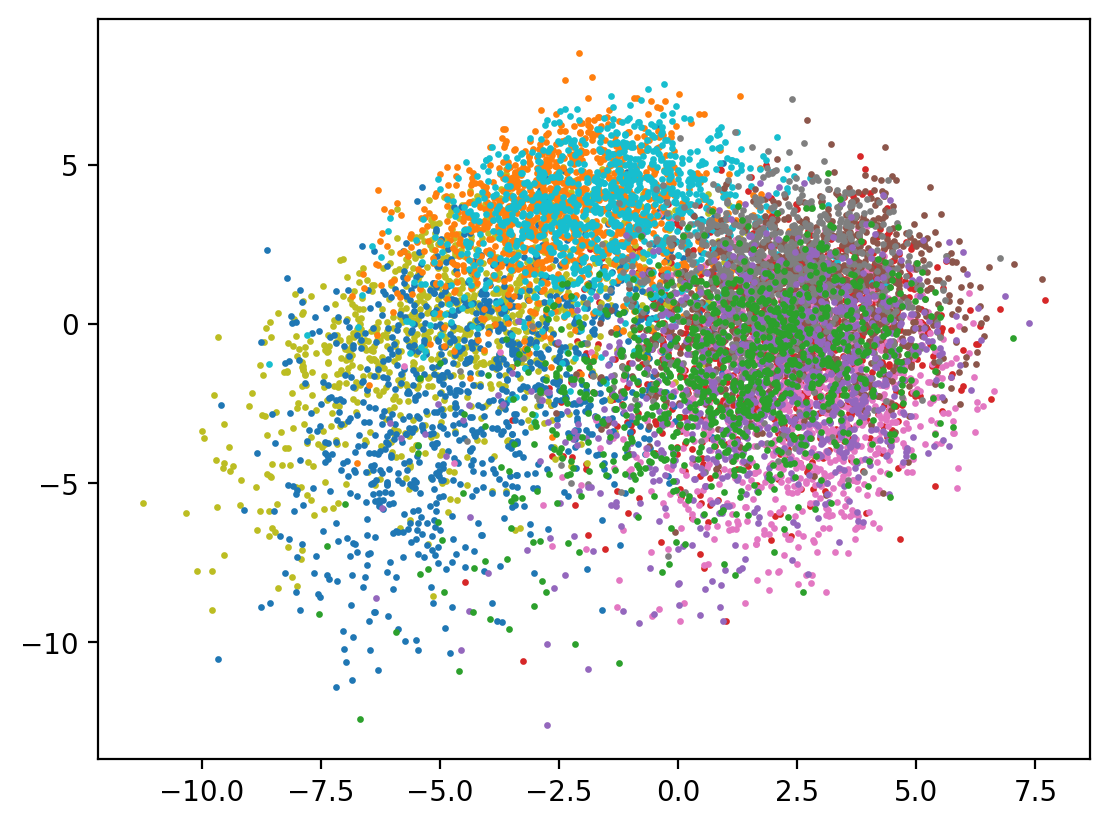

In [5]:
# introspect the producer (see the preceding pipeline) and produce
# a pipeline stage that can do a 2d projection.
pca = DimensionReduction.introspect(
    producer, batch_size=BATCH_SIZE,
    strategies=DimensionReduction.Strategy.PCA(2)
)

# apply the 2d projection to the original 1024-dimension data
pca_reduced = pipeline(producer, pca)

# and display it
show(pca_reduced)

#### Partial Reduction for Other Algorithms

As mentioned previously, many algorithms work better with lower dimension inputs, e.g. 40 dimensions, and dimension reduction algorithms (other than PCA) are no exception.  This has the added benefit of reducing the memory used when accumulating the data for the fit (first pass).

- https://umap-learn.readthedocs.io/en/0.5dev/faq.html

Prepare a PCA reducer that produces 40 dimension output and a pipeline that encapsulates that.

In [6]:
partial_reducer = DimensionReduction.introspect(
    producer, batch_size=BATCH_SIZE,
    strategies=DimensionReduction.Strategy.PCA(40))
partially_reduced = pipeline(producer, partial_reducer)

INFO:dnikit.base._cached_producer.Cacher:Using cached batches. Attempting to retrieve values..


### t-SNE

t-distributed Stochastic Neighbor Embedding (t-SNE) is a more sophisticated dimension reduction technique that tries to maintain local structure.

> t-SNE (TSNE) converts affinities of data points to probabilities. The affinities in the original space are represented by Gaussian joint probabilities and the affinities in the embedded space are represented by Student’s t-distributions. This allows t-SNE to be particularly sensitive to local structure and has a few other advantages over existing techniques:
> - Revealing the structure at many scales on a single map
> - Revealing data that lie in multiple, different, manifolds or clusters
> - Reducing the tendency to crowd points together at the center

- [How to Use t-SNE Effectively](https://distill.pub/2016/misread-tsne/)
- [SciKit Learn Description](https://scikit-learn.org/stable/modules/manifold.html#t-sne)


It has a number of tuning parameters, the most important being `perplexity`:

- [Parameter Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)
- [Exploring Perplexity](https://scikit-learn.org/stable/auto_examples/manifold/plot_t_sne_perplexity.html#sphx-glr-auto-examples-manifold-plot-t-sne-perplexity-py)

Use the 40 dimensional projection defined earlier and use t-SNE to do the further reduction to 2D.  This produces a much clearer separation of classes than PCA was able to obtain.

**Pros**

- better 2D projection than PCA

**Cons**

- slow
- `UMAP` (shown later) is generally preferred

INFO:dnikit.base._cached_producer.Cacher:Using cached batches. Attempting to retrieve values..


INFO:dnikit.base._cached_producer.Cacher:Using cached batches. Attempting to retrieve values..


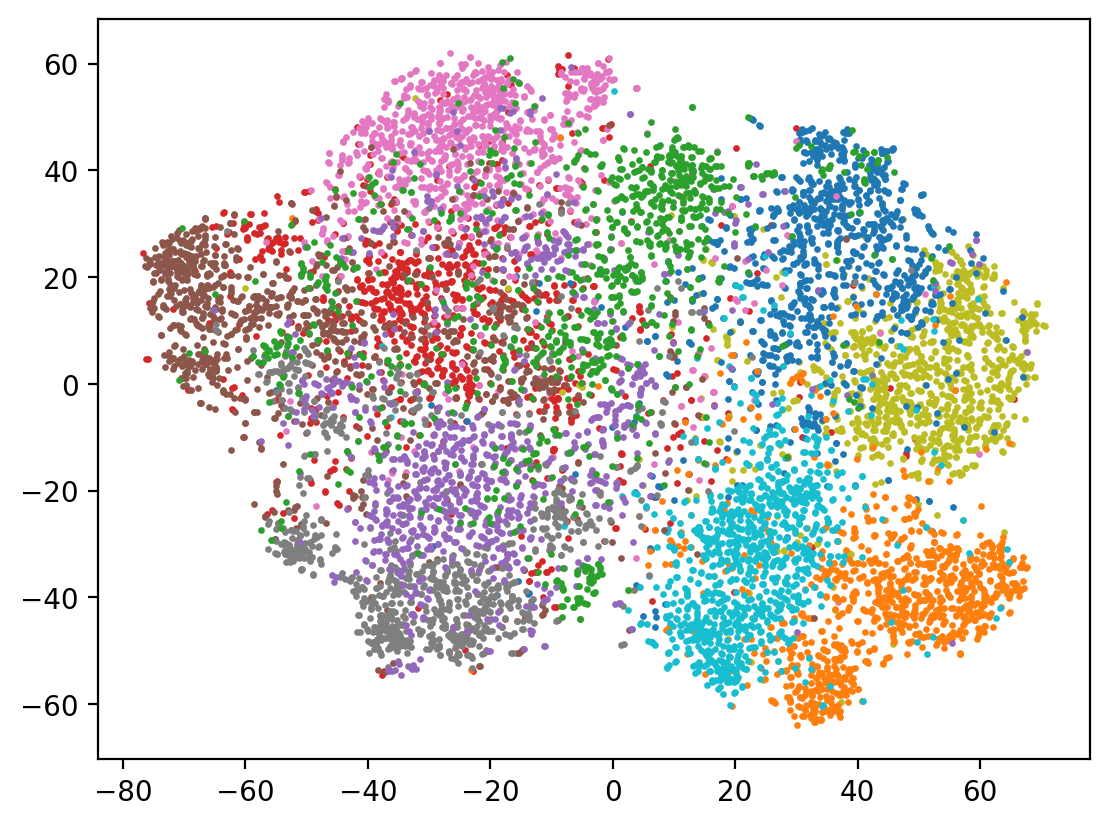

In [7]:
tsne = DimensionReduction.introspect(
    partially_reduced, batch_size=BATCH_SIZE, 
    strategies=DimensionReduction.Strategy.TSNE(2))
tsne_reduced = pipeline(partially_reduced, tsne)

show(tsne_reduced)

### UMAP

UMAP is another popular dimension reduction technique:

> Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction. The algorithm is founded on three assumptions about the data
>
> - The data is uniformly distributed on Riemannian manifold;
> - The Riemannian metric is locally constant (or can be approximated as such);
> - The manifold is locally connected.

- [Understanding UMAP](https://pair-code.github.io/understanding-umap/)
- [Documentation](https://umap-learn.readthedocs.io/en/0.5dev/index.html) -- include tips on parameters and how to use it
- [Paper](https://arxiv.org/abs/1802.03426)

Shown in the next cell, UMAP provides an even greater separation of the embedding space with regard to class.

**Pros**

- produces very good 2D projections
- local structure is preserved
- faster than t-SNE but slower than PCA

**Cons**

- does not preserve global structure, see `PaCMAP` later

/private/tmp/dnikit-2.0.0/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/private/tmp/dnikit-2.0.0/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/private/tmp/dnikit-2.0.0/lib/python3.9/site-packages/umap/distances.py:1086: NumbaDepreca

/private/tmp/dnikit-2.0.0/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/private/tmp/dnikit-2.0.0/lib/python3.9/site-packages/umap/umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
INFO:dnikit.base._cached_producer.Cacher:Using cached batches. Attempting to retrieve values..


INFO:dnikit.base._cached_producer.Cacher:Using cached batches. Attempting to retrieve values..


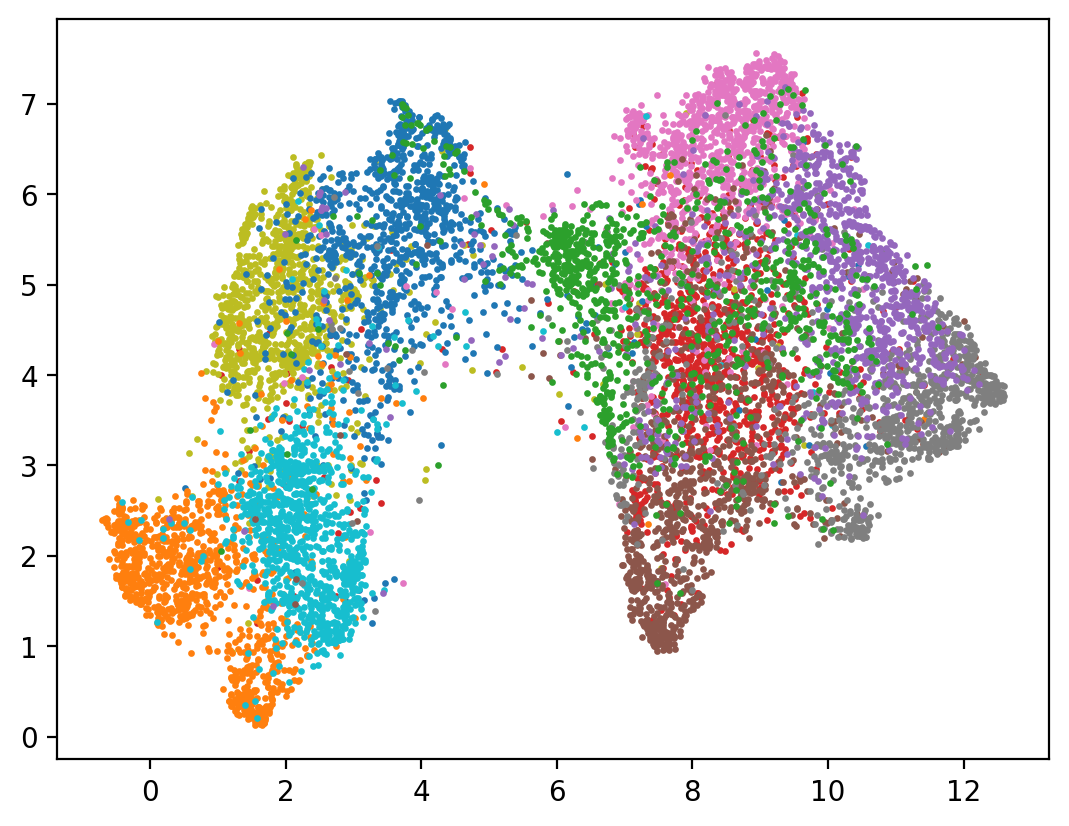

In [8]:
umap = DimensionReduction.introspect(
    partially_reduced, batch_size=BATCH_SIZE,
    strategies=DimensionReduction.Strategy.UMAP(2))

umap_reduced = pipeline(partially_reduced, umap)

show(umap_reduced)

### PaCMAP

The final DimensionReduction algorithm integrated into DNIKit is called PaCMAP:

> PaCMAP (Pairwise Controlled Manifold Approximation) is a dimensionality reduction method that can be used for visualization, preserving both local and global structure of the data in original space. PaCMAP optimizes the low dimensional embedding using three kinds of pairs of points: neighbor pairs (pair_neighbors), mid-near pair (pair_MN), and further pairs (pair_FP).
>
> Previous dimensionality reduction techniques focus on either local structure (e.g. t-SNE, LargeVis and UMAP) or global structure (e.g. TriMAP), but not both, although with carefully tuning the parameter in their algorithms that controls the balance between global and local structure, which mainly adjusts the number of considered neighbors. Instead of considering more neighbors to attract for preserving local structure, PaCMAP dynamically uses a special group of pairs -- mid-near pairs, to first capture global structure and then refine local structure, which both preserve global and local structure. For a thorough background and discussion on this work, please read [this paper](https://jmlr.org/papers/v22/20-1061.html).

- https://github.com/YingfanWang/PaCMAP

Much like UMAP, this gives a very strong separation of points in the embedding space with regard to class.  This algorithm has a number of tuning parameters that can be used to control it -- please read their website (listed earlier) for more information.

**Pros**

- designed to keep both local and global structure

INFO:dnikit.base._cached_producer.Cacher:Using cached batches. Attempting to retrieve values..


INFO:dnikit.base._cached_producer.Cacher:Using cached batches. Attempting to retrieve values..


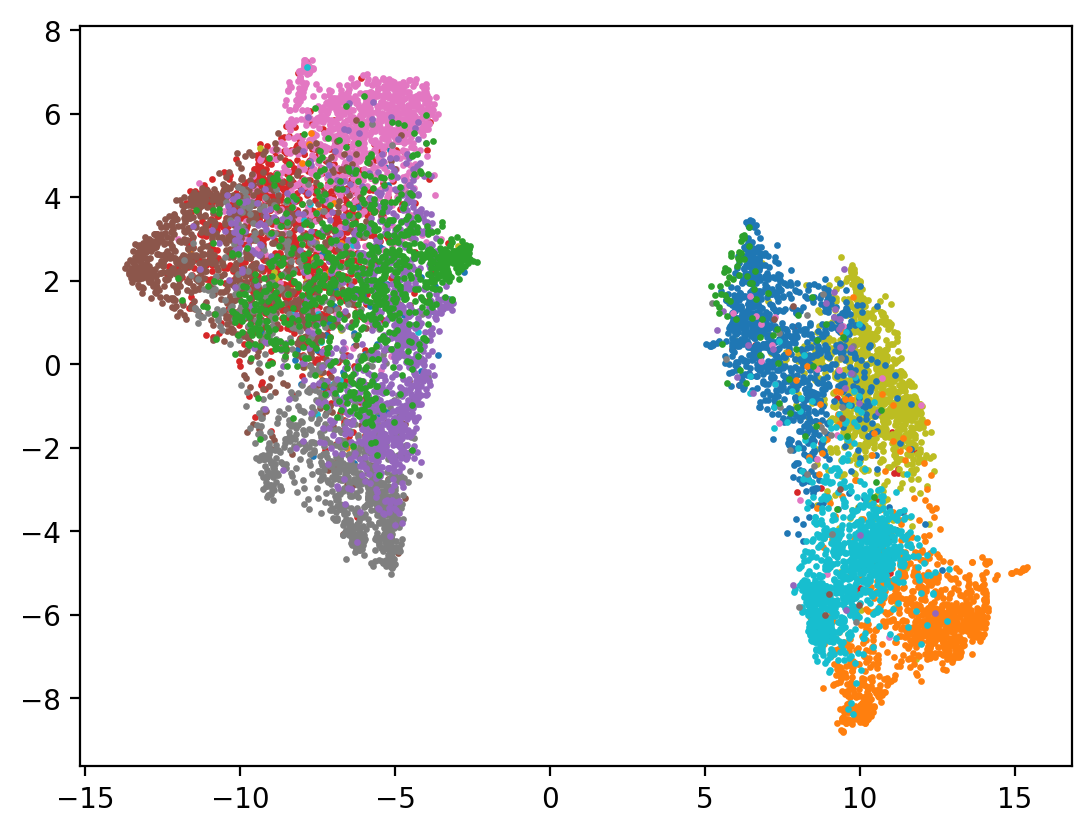

In [9]:
pacmap = DimensionReduction.introspect(
    partially_reduced, batch_size=BATCH_SIZE, 
    strategies=DimensionReduction.Strategy.PaCMAP(2))

pacmap_reduced = pipeline(partially_reduced, pacmap)

show(pacmap_reduced)